# Bài 1

In [4]:
# import libs
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Activation, Add, Dense, Conv2D, MaxPool2D, AveragePooling2D, BatchNormalization, Input, ZeroPadding2D, AveragePooling2D, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imutils import paths
from keras.applications import vgg16
from keras.applications import imagenet_utils
from tensorflow.keras.utils import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Flatten
import random
import os

In [5]:
# load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [6]:
# parameters
NUM_CLASSES = np.unique(y_train).shape[0]
BATCH_SIZE = 32
EPOCHS = 50
COLORS = 3

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=10_000)

print('Train size: \t', x_train.shape[0])
print('Val size: \t', x_val.shape[0])
print('Test size: \t', x_test.shape[0])

Train size: 	 40000
Val size: 	 10000
Test size: 	 10000


In [8]:
# normalize input
x_train = x_train / 255.
x_test = x_test / 255.
x_val = x_val / 255.

# One-hot
y_test = np_utils.to_categorical(y_test, NUM_CLASSES)
y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
y_val = np_utils.to_categorical(y_val, NUM_CLASSES)

print(y_test[0])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [9]:
# define residual block
# X: input
# filters: filter size array
def residual_block(X, filters, isPooling=False):
    # save a copy
    X_copy = X

    num_layers = len(filters)

    stride = (1, 1)

    if isPooling:
        stride = (2, 2)

    # first layers
    X = ZeroPadding2D((1, 1))(X)
    X = Conv2D(filters[0], (3, 3), padding='valid', strides=stride)(X)
    # N * H * W * D
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # iterate each layer
    for i in range(1, num_layers - 1):
        X = Conv2D(filters[i], (3, 3), padding='same')(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)

    # last layer
    X = Conv2D(filters[-1], (3, 3), padding='same')(X)
    X = BatchNormalization(axis=3)(X)

    # resize x_copy if needed
    if isPooling:
        X_copy = Conv2D(filters[-1], (1, 1),
                        strides=stride, padding='same')(X_copy)
        X_copy = BatchNormalization(axis=3)(X_copy)

    # add x
    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    return X


In [10]:
# define ResNet model
def ResNet(input_shape, num_classes):

    # input
    X_input = Input(input_shape)

    # padding before convolution
    X = ZeroPadding2D((3, 3))(X_input)

    # first stage
    X = Conv2D(64, (3, 3), strides=(2, 2))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPool2D()(X)

    # residual block
    X = residual_block(X, [64, 64, 64], False)
    X = residual_block(X, [64, 64, 64], False)
    X = residual_block(X, [64, 64, 64], False)

    X = residual_block(X, [128, 128, 128], True)

    X = residual_block(X, [128, 128, 128], False)
    X = residual_block(X, [128, 128, 128], False)

    # final stage
    X = AveragePooling2D()(X)

    # Output layer
    X = Flatten()(X)

    X = Dropout(0.4)(X)
    X = Dense(256, activation='relu')(X)
    X = Dropout(0.4)(X)
    X = Dense(128, activation='relu')(X)
    X = Dropout(0.4)(X)
    X = Dense(num_classes, activation='softmax')(X)

    # Build model
    model = Model(inputs=X_input, outputs=X, name='CustomResNet')

    return model


In [11]:
# data shape
x_train[0].shape

(32, 32, 3)

In [12]:
model = ResNet(input_shape=(32, 32, 3), num_classes=NUM_CLASSES)
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
model.summary()

Model: "CustomResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 18, 18, 64)   1792        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 18, 18, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                            

In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
H = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
              validation_data=(x_val, y_val), verbose=0, callbacks=[es])


Epoch 16: early stopping


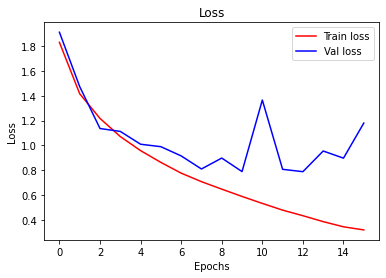

In [15]:
# Loss
plt.plot(H.history['loss'], 'r-')
plt.plot(H.history['val_loss'], 'b-')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train loss', 'Val loss'])
plt.show()


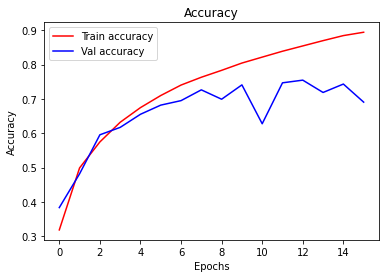

In [16]:
# Accuracy
plt.plot(H.history['accuracy'], 'r-')
plt.plot(H.history['val_accuracy'], 'b-')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train accuracy', 'Val accuracy'])
plt.show()

# Bài 2

In [17]:
X = np.array([3,3,0,-4]).reshape(2,2)
w0 = np.array([-2,-2]).reshape(-1, 1)

In [19]:
X.dot(w0)

array([[-12],
       [  8]])

In [20]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

In [23]:
sigmoid(X.dot(w0))

array([[6.1441746e-06],
       [9.9966465e-01]])

In [27]:
X = X.T

In [28]:
X

array([[ 3,  3],
       [ 0, -4]])

In [31]:
sigmoid(X.dot(np.array([-1.8, -1.2]).reshape(-1, 1)))

array([[1.23394576e-04],
       [9.91837429e-01]])

In [36]:
a = np.array([17, 13, 17, 10]).reshape(1, 4)
b = np.array([[3, 0, 2],
              [1, 3, 0],
              [1, 1, 1],
              [0, 1, 4]]).reshape(4, 3)


In [37]:
a.dot(b)

array([[81, 66, 91]])

In [38]:
def softmax(Z):
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis = 1, keepdims= True)
    return A

In [39]:
softmax(np.array([81, 70, 94]).reshape(-1, 3))

array([[2.26032430e-06, 3.77512601e-11, 9.99997740e-01]])

In [40]:
from keras.models import Sequential


In [42]:
model = Sequential()

model.add(Conv2D(64, (5, 5), strides=2, padding='valid',
          activation='relu', input_shape=(256, 256, 3)))
model.add(Conv2D(2, (5, 5), padding='valid', activation='relu'))

model.add(Flatten())
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 126, 126, 64)      4864      
                                                                 
 conv2d_23 (Conv2D)          (None, 122, 122, 2)       3202      
                                                                 
 flatten_2 (Flatten)         (None, 29768)             0         
                                                                 
Total params: 8,066
Trainable params: 8,066
Non-trainable params: 0
_________________________________________________________________


In [43]:
X = np.array([[4.2223],
              [-3.9713],
              [4.4673],
              [-1.9038],
              [-2.2165],
              [-4.9564],
              [2.2877],
              [-1.5485],
              [-1.6914],
              [0.6228],
              [1.8679],
              [2.0898],
              [2.0042],
              [-2.4138],
              [1.1985],
              [-4.2988],
              [0.8784],
              [3.9534],
              [4.9538],
              [-1.0472]])
Y = np.array([[255.5464],
              [-163.8420],
              [299.5179],
              [-16.3115],
              [-26.4654],
              [-324.0216],
              [49.1635],
              [-8.2638],
              [-11.1184],
              [4.5332],
              [30.0069],
              [39.2643],
              [35.5587],
              [-34.8183],
              [11.6482],
              [-209.1456],
              [6.9089],
              [212.7225],
              [401.3659],
              [-1.7155]])


In [44]:
X.shape

(20, 1)

In [45]:
Y.shape

(20, 1)